In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\00100
00100


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]

if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
start_index = 1
i_range = range(start_index, limit,i_stepsize)
i_range_0 = range(start_index, limit,i_stepsize)
i_range_1 = range(start_index, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  1 0.4250000000000001 0.3500000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  1 0.4250000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9816.271887816363
Gradient descend method:  None
RUN  0 , total integrated cost =  9816.271887816363
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  3 0.4250000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9705.568895421273
Gradient descend method:  None
RUN  0 , total integrated cost =  9705.568895421273
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  5 0.4000000000000001 0.40000000000000013
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5097.289828199723
Gradient descend method:  None
RUN  0 , total integrated cost =  5097.289828199723
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  7 0.4500000000000001 0.40000000000000013
s

In [14]:
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  1 0.4250000000000001 0.3500000000000001
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
-------  23 0.5250000000000001 0.4750000000000002
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003

--------- 1


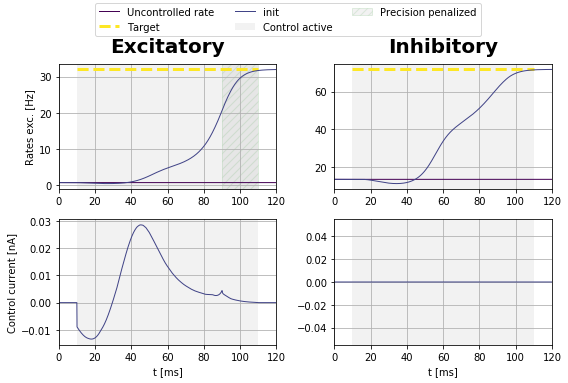

--------- 3


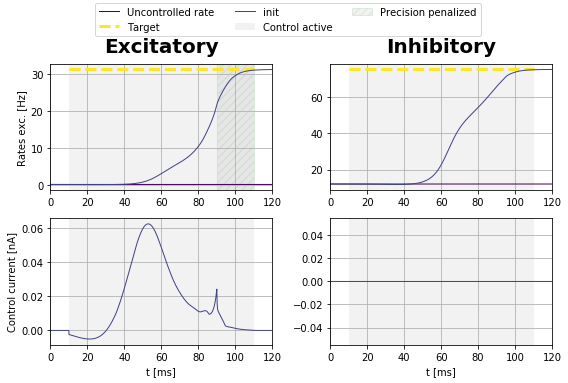

--------- 5


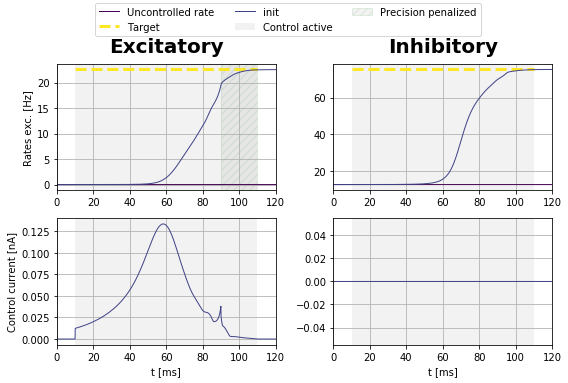

--------- 7


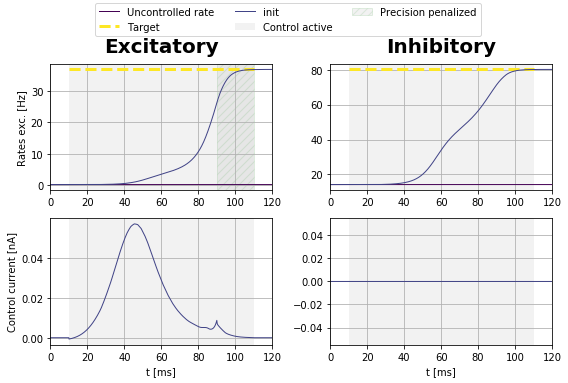

--------- 9


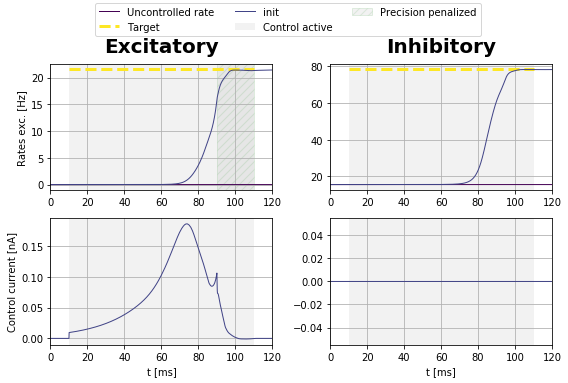

--------- 11


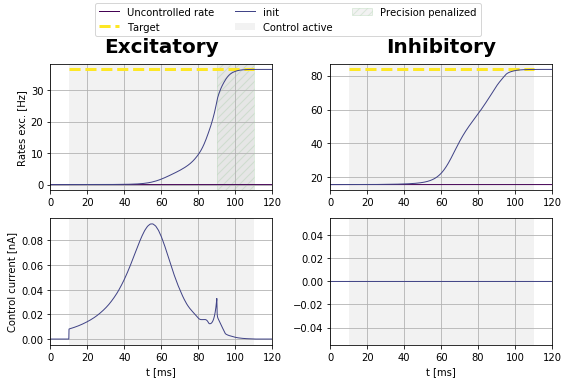

--------- 13


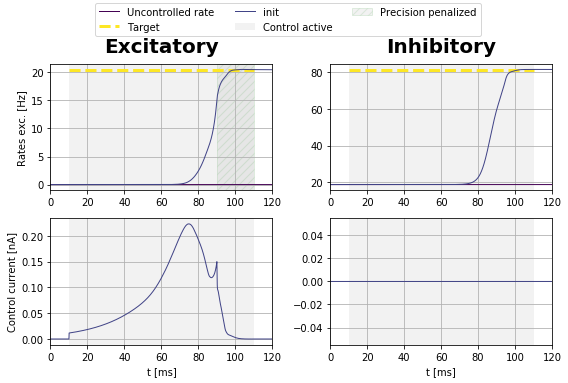

--------- 15


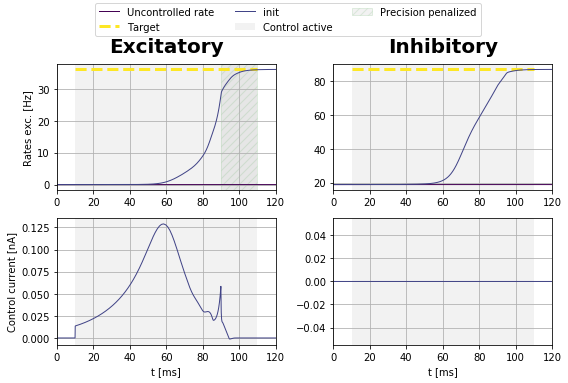

--------- 17


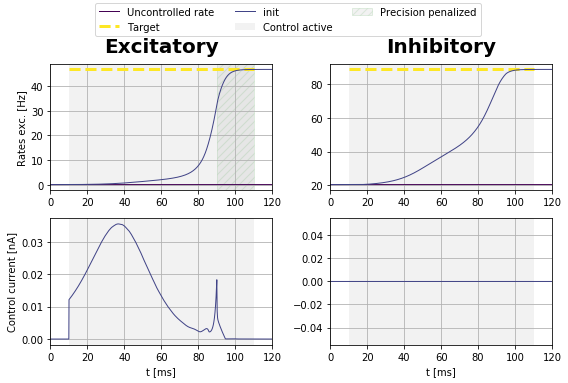

--------- 19


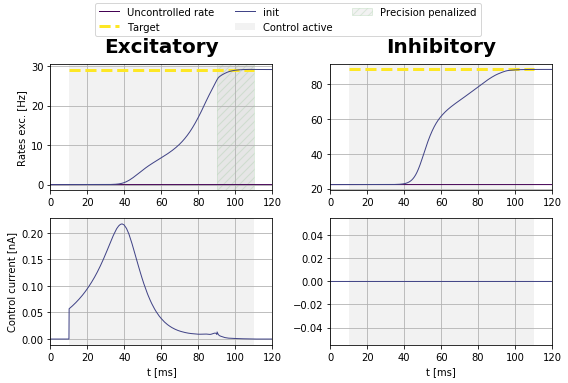

--------- 21


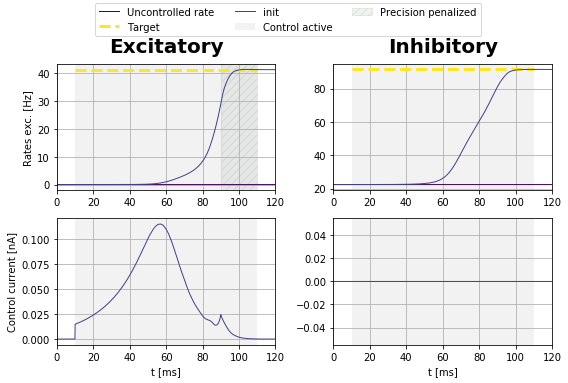

--------- 23


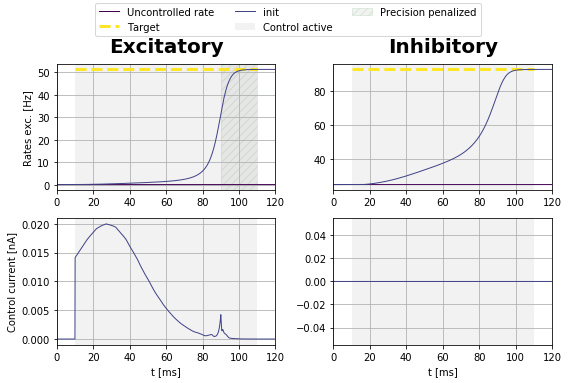

--------- 25


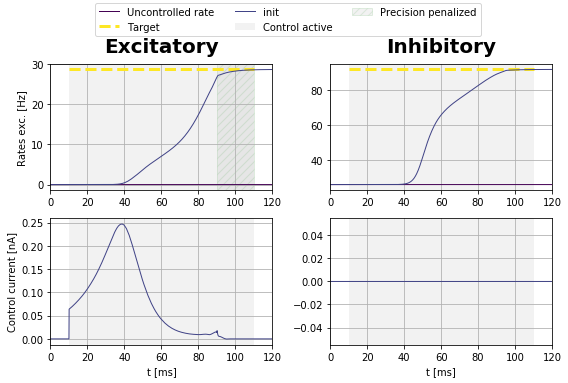

--------- 27


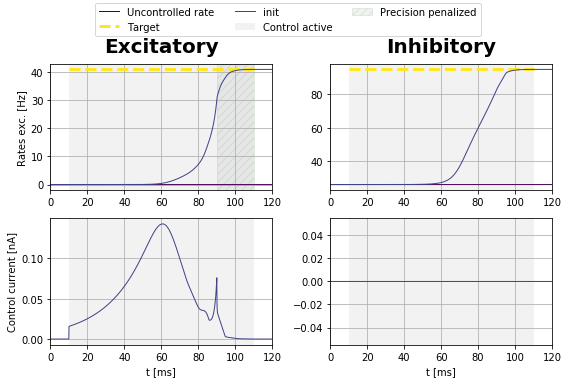

--------- 29


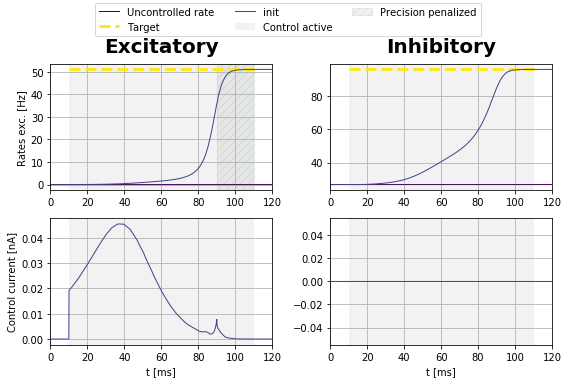

--------- 31


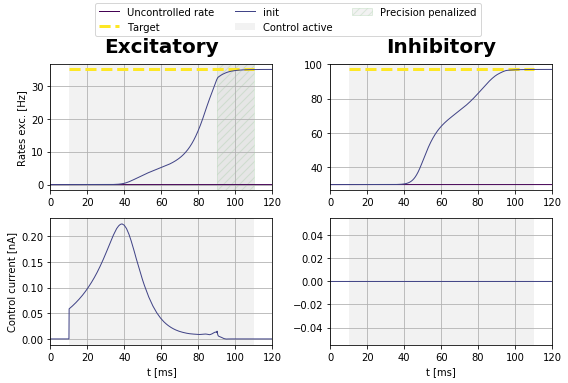

--------- 33


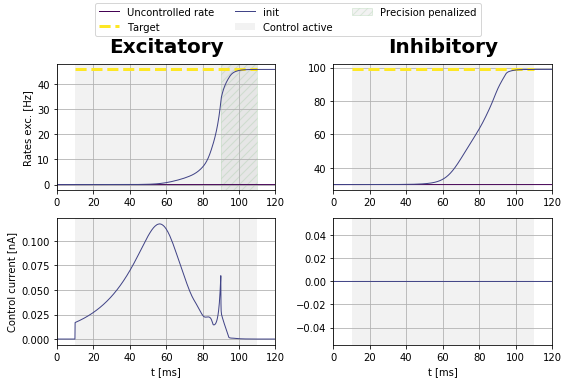

--------- 35


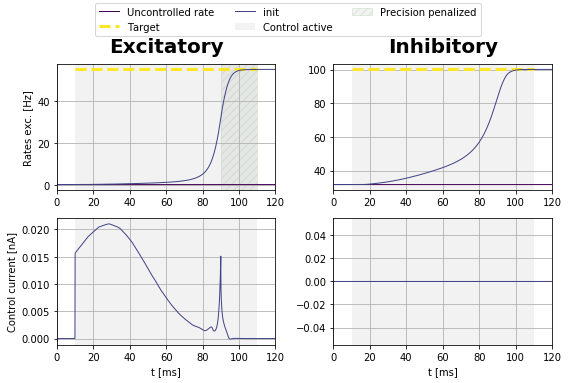

--------- 37


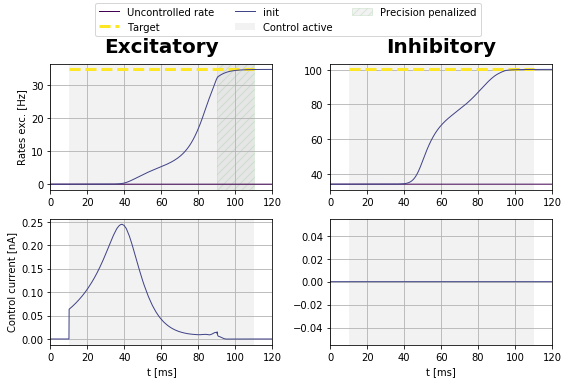

--------- 39


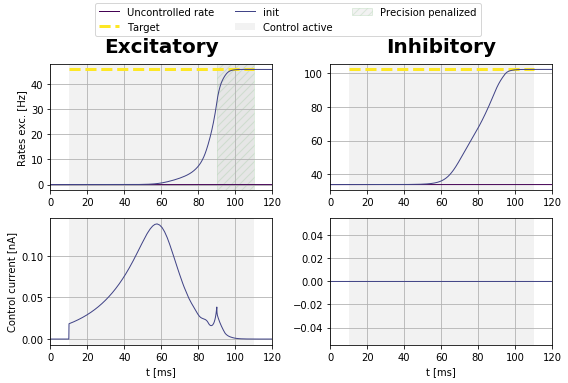

In [15]:
#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [16]:
found_solution = []
no_solution = []
factor_iteration = 1.
already_tried = [ [] for _ in range(len(exc)) ]

for k in range(len(i_range)**2):
    print('------------------------------------------------------------')
    print('--------------------', k)
    print('------------------------------------------------------------')
        
    print("found solution: ", found_solution)
    print("no solution: ", no_solution)
    
    if len(i_range) == len(found_solution) + len(no_solution):
        print("found solution for all parameters")
        break


    for i in i_range:
        print("------- ", i, exc[i], inh[i])     

        if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-300:]) - target[i][0,1,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amax(
            bestState_init[i][0,0,:]) < target[i][0,0,-1] + 1. and np.amax(
            bestState_init[i][0,1,:]) < target[i][0,1,-1] + 1.:
            # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
            #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
            if i not in found_solution:
                print("found solution for ", i)
                found_solution.append(i)
            if i in no_solution:
                no_solution.pop(no_solution.index(i))
            continue

        if len(found_solution) == 0:
            continue
            
        closest_ = getclosest(i, found_solution, exc, inh, already_tried[i])
        print("closest index ", closest_)

        weight_ = 10
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
            
        if i != 0 and closest_ != -1:
            control0 = bestControl_init[closest_][:,:,n_pre-1:-n_post+1]
            if closest_ not in already_tried[i]:
                already_tried[i].append(closest_)
                        
        if closest_ == -1:
            print("all options tried already")
            if i not in no_solution:
                no_solution.append(i)
                continue

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(100 * factor_iteration)

        weights_init[i] = cost.getParams()
        
        print("precision vars = ", prec_vars)

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        j = 1
        while cost_init[i][-j] == 0.:
            j += 1

        weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int(500 * factor_iteration)

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)

------------------------------------------------------------
-------------------- 0
------------------------------------------------------------
found solution:  []
no solution:  []
-------  1 0.4250000000000001 0.3500000000000001
found solution for  1
-------  3 0.4250000000000001 0.3750000000000001
found solution for  3
-------  5 0.4000000000000001 0.40000000000000013
found solution for  5
-------  7 0.4500000000000001 0.40000000000000013
found solution for  7
-------  9 0.4000000000000001 0.42500000000000016
found solution for  9
-------  11 0.4500000000000001 0.42500000000000016
found solution for  11
-------  13 0.4000000000000001 0.4500000000000002
found solution for  13
-------  15 0.4500000000000001 0.4500000000000002
found solution for  15
-------  17 0.5000000000000002 0.4500000000000002
found solution for  17
-------  19 0.4250000000000001 0.4750000000000002
found solution for  19
-------  21 0.47500000000000014 0.4750000000000002
found solution for  21
-------  23 0.525000

In [17]:
factor_iteration = 20
full_converge = False
conv_init = [[False]*2] * len(exc)

for i in range(len(conv_init)):
    if i not in i_range:
        conv_init[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print("------------------------------------------------")
    print('-------------------------', counter)
    
    if counter > 20:
        break
        
    print(conv_init[start_index:limit:i_stepsize])
    full_converge = True
    
    for conv in conv_init[start_index:limit:i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_init[i] == [True, True]:
            continue
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        j = 1
        while cost_init[i][-j] == 0.:
            j += 1
                       
        weight_ = (factor_we * weights_init[i][1] * cost_uncontrolled[i] / cost_init[i][-j]
                   + factor_ws * weights_init[i][2] * cost_uncontrolled[i] / cost_init[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        setinit(initVars[i], aln)
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_init[i] = cost.getParams()

        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(init_file,'wb') as f:
            pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                         costnode_init, weights_init], f)
            
        if j == cost_init[i].shape[0]-1:
            print("converged for ", i)
            if conv_init[i][0]:
                conv_init[i] = [True, True]
            else:
                conv_init[i] = [True, False]
            continue
    
        print("no convergence")
            
    counter += 1

------------------------------------------------
------------------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  14738.13227538413
set cost params:  1.0 0.0 14738.13227538413
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9797.914190272979
Gradient descend method:  None
RUN  1 , total integrated cost =  9797.285991505683
RUN  2 , total integrated cost =  9797.282098357287
RUN  3 , total integrated cost =  9797.282098298137
RUN  4 , total integrated cost =  9797.282098297612
RUN  5 , total integrated cost =  9797.2820982976


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  9797.282098297599
RUN  7 , total integrated cost =  9797.282098297588
RUN  8 , total integrated cost =  9797.282098297586
State only changes marginally.
RUN  9 , total integrated cost =  9797.282098297586
Control only changes marginally.
RUN  9 , total integrated cost =  9797.282098297586
Improved over  9  iterations in  0.2888345000000072  seconds by  0.006451291194409237  percent.
Problem in initial value trasfer:  Vmean_exc -56.65367409032176 -56.65369744419313
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  7057.215697156138
set cost params:  1.0 0.0 7057.215697156138
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9699.027277564162
Gradient descend method:  None
RUN  1 , total integrated cost =  9698.990053018097
RUN  2 , total integrated cost =  9698.984143984073
RUN  3 , total integrated cost =  9698.98304441804
RUN  4 , total integrated cost =  9698.982779655034
RUN  5 , total integrated cost = 

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  9698.982578500165
RUN  16 , total integrated cost =  9698.982578499827
RUN  17 , total integrated cost =  9698.982578499707
RUN  18 , total integrated cost =  9698.982578499701
RUN  19 , total integrated cost =  9698.982578499694
RUN  20 , total integrated cost =  9698.982578499685
Control only changes marginally.
RUN  21 , total integrated cost =  9698.982578499685
Improved over  21  iterations in  0.5470920999999862  seconds by  0.00046086131318645585  percent.
Problem in initial value trasfer:  Vmean_exc -56.65109867881172 -56.65111130999422


ERROR:root:Problem in initial value trasfer


no convergence
-------  5 0.4000000000000001 0.40000000000000013
weight =  1606.5391930510577
set cost params:  1.0 0.0 1606.5391930510577
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5094.118963159397
Gradient descend method:  None
RUN  1 , total integrated cost =  5094.118963159397
Control only changes marginally.
RUN  1 , total integrated cost =  5094.118963159397
Improved over  1  iterations in  0.07038620000002993  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62449176144705 -56.62448913150031
converged for  5
-------  7 0.4500000000000001 0.40000000000000013
weight =  10350.607856335913
set cost params:  1.0 0.0 10350.607856335913
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13551.641468428248
Gradient descend method:  None
RUN  1 , total integrated cost =  13551.5926318363
RUN  2 , total integrated cost =  13551.59165278803
RUN  3 , total integrated cost =  13551.59162887377
RUN  4 , total integra

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13551.59162810785
RUN  7 , total integrated cost =  13551.59162810785
Control only changes marginally.
RUN  7 , total integrated cost =  13551.59162810785
Improved over  7  iterations in  0.26665809999997236  seconds by  0.0003677806892596891  percent.
Problem in initial value trasfer:  Vmean_exc -56.6739945547162 -56.6739980636254
no convergence
-------  9 0.4000000000000001 0.42500000000000016
weight =  1053.4112982666852
set cost params:  1.0 0.0 1053.4112982666852
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4635.654114275694
Gradient descend method:  None
RUN  1 , total integrated cost =  4623.082381943975
RUN  2 , total integrated cost =  4615.504158897482
RUN  3 , total integrated cost =  4607.8757010901845
RUN  4 , total integrated cost =  4607.15913309713
RUN  5 , total integrated cost =  4572.552565471347
RUN  6 , total integrated cost =  4566.889073718708
RUN  7 , total integrated cost =  4566.773965229545
RUN  8 ,

ERROR:root:Problem in initial value trasfer


RUN  60 , total integrated cost =  4532.152496285579
Control only changes marginally.
RUN  63 , total integrated cost =  4532.152496285577
Improved over  63  iterations in  1.5087051000000429  seconds by  2.232729522924913  percent.
Problem in initial value trasfer:  Vmean_exc -56.62550977426706 -56.625505502502115
no convergence
-------  11 0.4500000000000001 0.42500000000000016
weight =  5975.018713663433
set cost params:  1.0 0.0 5975.018713663433
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13307.178021926818
Gradient descend method:  None
RUN  1 , total integrated cost =  13307.163733881293
RUN  2 , total integrated cost =  13307.162715703696
RUN  3 , total integrated cost =  13307.162650958559
RUN  4 , total integrated cost =  13307.162649454971
RUN  5 , total integrated cost =  13307.162649338103
RUN  6 , total integrated cost =  13307.162649328986


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  13307.162649328227
RUN  8 , total integrated cost =  13307.16264932814
RUN  9 , total integrated cost =  13307.162649328133
RUN  10 , total integrated cost =  13307.162649328127
RUN  11 , total integrated cost =  13307.162649328124
RUN  12 , total integrated cost =  13307.162649328124
Control only changes marginally.
RUN  12 , total integrated cost =  13307.162649328124
Improved over  12  iterations in  0.36712249999993674  seconds by  0.00011552110198920218  percent.
Problem in initial value trasfer:  Vmean_exc -56.67234162788227 -56.67234008927813
no convergence
-------  13 0.4000000000000001 0.4500000000000002
weight =  797.3364968412387
set cost params:  1.0 0.0 797.3364968412387
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4171.7289245289
Gradient descend method:  None
RUN  1 , total integrated cost =  4171.728311877591
RUN  2 , total integrated cost =  4171.728224631282
RUN  3 , total integrated cost =  4171.72820982352

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  4171.728206957533
RUN  9 , total integrated cost =  4171.728206957269
RUN  10 , total integrated cost =  4171.728206957225
RUN  11 , total integrated cost =  4171.728206957216
RUN  12 , total integrated cost =  4171.728206957216
Control only changes marginally.
RUN  12 , total integrated cost =  4171.728206957216
Improved over  12  iterations in  0.32623420000004444  seconds by  1.7200822426843843e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.627221031848485 -56.62722196463057


ERROR:root:Problem in initial value trasfer


no convergence
-------  15 0.4500000000000001 0.4500000000000002
weight =  4149.910903632359
set cost params:  1.0 0.0 4149.910903632359
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13014.938443270057
Gradient descend method:  None
RUN  1 , total integrated cost =  13014.938443270057
Control only changes marginally.
RUN  1 , total integrated cost =  13014.938443270057
Improved over  1  iterations in  0.07086839999999484  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67034591137781 -56.670353653188315
converged for  15
-------  17 0.5000000000000002 0.4500000000000002
weight =  22513.283383754857
set cost params:  1.0 0.0 22513.283383754857
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21760.411561372115
Gradient descend method:  None
RUN  1 , total integrated cost =  21760.40881414083
RUN  2 , total integrated cost =  21760.406975254267
RUN  3 , total integrated cost =  21760.405778941265
RUN  4 , total i

ERROR:root:Problem in initial value trasfer



RUN  38 , total integrated cost =  21732.79575891169
Improved over  38  iterations in  1.0171925999999303  seconds by  0.1269084565911811  percent.
Problem in initial value trasfer:  Vmean_exc -56.698906715614214 -56.69890737114506
no convergence
-------  19 0.4250000000000001 0.4750000000000002
weight =  1734.4280497070963
set cost params:  1.0 0.0 1734.4280497070963
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8498.60087238862
Gradient descend method:  None
RUN  1 , total integrated cost =  8498.60085599218
RUN  2 , total integrated cost =  8498.600855640454
RUN  3 , total integrated cost =  8498.600855624893
RUN  4 , total integrated cost =  8498.600855624543
RUN  5 , total integrated cost =  8498.600855624529
RUN  6 , total integrated cost =  8498.600855624525
RUN  7 , total integrated cost =  8498.600855624522
RUN 

ERROR:root:Problem in initial value trasfer


 8 , total integrated cost =  8498.60085562452
RUN  9 , total integrated cost =  8498.60085562452
Control only changes marginally.
RUN  9 , total integrated cost =  8498.60085562452
Improved over  9  iterations in  0.4071649999999636  seconds by  1.9725719369034778e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.64198700350471 -56.64198282971308
no convergence
-------  21 0.47500000000000014 0.4750000000000002
weight =  5943.641984246187
set cost params:  1.0 0.0 5943.641984246187
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17063.764176388733
Gradient descend method:  None
RUN  1 , total integrated cost =  17063.745487234082
RUN  2 , total integrated cost =  17063.744838935818
RUN  3 , total integrated cost =  17063.744807378273
RUN  4 , total integrated cost =  17063.744807124433
RUN  5 , total integrated cost =  17063.744807124418
RUN  6 , total integrated cost =  17063.744807124414


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  17063.744807124414
Control only changes marginally.
RUN  7 , total integrated cost =  17063.744807124414
Improved over  7  iterations in  0.27948399999991125  seconds by  0.00011351108769019902  percent.
Problem in initial value trasfer:  Vmean_exc -56.687614913483856 -56.6876109241529
no convergence
-------  23 0.5250000000000001 0.4750000000000002
weight =  46045.98879486441
set cost params:  1.0 0.0 46045.98879486441
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26092.16883710998
Gradient descend method:  None
RUN  1 , total integrated cost =  26091.543436187334
RUN  2 , total integrated cost =  26091.543436187327


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  26091.543436187327
Control only changes marginally.
RUN  3 , total integrated cost =  26091.543436187327
Improved over  3  iterations in  0.18500030000006973  seconds by  0.002396891291638781  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352430164158 -56.703524468179964
no convergence
-------  25 0.4250000000000001 0.5000000000000002
weight =  1478.4467551238238
set cost params:  1.0 0.0 1478.4467551238238
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8226.34304202541
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  8226.34304202541
Control only changes marginally.
RUN  1 , total integrated cost =  8226.34304202541
Improved over  1  iterations in  0.07524390000003223  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63943175236916 -56.63943716939168
converged for  25
-------  27 0.47500000000000014 0.5000000000000002
weight =  4708.667295054418
set cost params:  1.0 0.0 4708.667295054418
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16805.00299355994
Gradient descend method:  None
RUN  1 , total integrated cost =  16805.001235159038
RUN  2 , total integrated cost =  16805.000798583063
RUN  3 , total integrated cost =  16805.000681237776
RUN  4 , total integrated cost =  16805.000665830834
RUN  5 , total integrated cost =  16805.00066164833
RUN  6 , total integrated cost =  16805.000660517795
RUN  7 , total integrated cost =  16805.000660169313
RUN  8 , total integrated cost =  16805.000660066667
RUN  9 , total integr

ERROR:root:Problem in initial value trasfer


RUN  16 , total integrated cost =  16805.000660025595
RUN  17 , total integrated cost =  16805.00066002559
RUN  18 , total integrated cost =  16805.000660025584
RUN  19 , total integrated cost =  16805.00066002558
RUN  20 , total integrated cost =  16805.00066002558
Control only changes marginally.
RUN  20 , total integrated cost =  16805.00066002558
Improved over  20  iterations in  0.6068662000000131  seconds by  1.3885950295389193e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.68658760969217 -56.68658752218464
no convergence
-------  29 0.5250000000000001 0.5000000000000002
weight =  20283.54598726136
set cost params:  1.0 0.0 20283.54598726136
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25979.362392519797
Gradient descend method:  None
RUN  1 , total integrated cost =  25979.29885964085
RUN  2 , total integrated cost =  25979.29885964083
RUN 

ERROR:root:Problem in initial value trasfer


 3 , total integrated cost =  25979.298859640825
RUN  4 , total integrated cost =  25979.298859640825
Control only changes marginally.
RUN  4 , total integrated cost =  25979.298859640825
Improved over  4  iterations in  0.2438448000000335  seconds by  0.0002445513404580879  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330272100355 -56.70330281511441
no convergence
-------  31 0.4500000000000001 0.5250000000000002
weight =  2416.20410772989
set cost params:  1.0 0.0 2416.20410772989
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12234.606506299826
Gradient descend method:  None
RUN  1 , total integrated cost =  12234.606499876945
RUN  2 , total integrated cost =  12234.606499794781
RUN  3 , total integrated cost =  12234.6064997936
RUN  4 , total integrated cost =  12234.606499793581
RUN  5 , total integrated cost =  12234.606499793577
RUN  6 , total integrated cost =  12234.606499793575
RUN  7 , total integrated cost =  12234.606499793575


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  7 , total integrated cost =  12234.606499793575
Improved over  7  iterations in  0.28098899999997684  seconds by  5.31790789182196e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.66599290680357 -56.66599615978698
no convergence
-------  33 0.5000000000000002 0.5250000000000002
weight =  6950.437288810603
set cost params:  1.0 0.0 6950.437288810603
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21064.36228278962
Gradient descend method:  None
RUN  1 , total integrated cost =  21064.362064256606
RUN  2 , total integrated cost =  21064.361848905377
RUN  3 , total integrated cost =  21064.361678030564
RUN  4 , total integrated cost =  21064.36162506763
RUN  5 , total integrated cost =  21064.3615812412
RUN  6 , total integrated cost =  21064.361525149077
RUN  7 , total integrated cost =  21064.361513910895
RUN  8 , total integrated cost =  21064.36151391089


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  21064.361513910877
RUN  10 , total integrated cost =  21064.361513910873
RUN  11 , total integrated cost =  21064.361513910873
Control only changes marginally.
RUN  11 , total integrated cost =  21064.361513910873
Improved over  11  iterations in  0.40198320000001786  seconds by  3.6501401723398885e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.69734858143995 -56.69734892127642
no convergence
-------  35 0.5500000000000003 0.5250000000000002
weight =  48505.63044819621
set cost params:  1.0 0.0 48505.63044819621

ERROR:root:Problem in initial value trasfer



interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30545.799246033537
Gradient descend method:  None
RUN  1 , total integrated cost =  30545.799246033537
Control only changes marginally.
RUN  1 , total integrated cost =  30545.799246033537
Improved over  1  iterations in  0.0992553000000953  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70443800849199 -56.7044379686261
converged for  35
-------  37 0.4500000000000001 0.5500000000000003
weight =  2179.068644983391
set cost params:  1.0 0.0 2179.068644983391
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.964739128958
Gradient descend method:  None
RUN  1 , total integrated cost =  12011.964737086759
RUN  2 , total integrated cost =  12011.964737061608
RUN  3 , total integrated cost =  12011.964737060876
RUN  4 , total integrated cost =  12011.964737060855


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12011.964737060855
Control only changes marginally.
RUN  5 , total integrated cost =  12011.964737060855
Improved over  5  iterations in  0.21838270000000648  seconds by  1.721703313251055e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.66464558390515 -56.664649056155866
no convergence
-------  39 0.5000000000000002 0.5500000000000003
weight =  5979.927704652528
set cost params:  1.0 0.0 5979.927704652528
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20835.338671918824
Gradient descend method:  None
RUN  1 , total integrated cost =  20835.32652536911
RUN  2 , total integrated cost =  20835.326087464207
RUN  3 , total integrated cost =  20835.326072790496
RUN  4 , total integrated cost =  20835.326072790493
RUN  5 , total integrated cost =  20835.326072790478
RUN  6 , total integrated cost =  20835.326072790474


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  20835.326072790474
Control only changes marginally.
RUN  7 , total integrated cost =  20835.326072790474
Improved over  7  iterations in  0.32568259999993643  seconds by  6.046999546072129e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.6969028730068 -56.696902201189765
no convergence
------------------------------------------------
------------------------- 1
[[False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  14765.698772398448
set cost params:  1.0 0.0 14765.698772398448
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.18078787978
Gradient descend method:  None
RUN  1 , total integrated co

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  9815.180284696304
RUN  6 , total integrated cost =  9815.180284696295
RUN  7 , total integrated cost =  9815.180284696291
RUN  8 , total integrated cost =  9815.180284696291
Control only changes marginally.
RUN  8 , total integrated cost =  9815.180284696291
Improved over  8  iterations in  0.34690890000001673  seconds by  5.126584028403158e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.653670821935236 -56.65369424022518
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  7061.008061591198
set cost params:  1.0 0.0 7061.008061591198
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.119374059626
Gradient descend method:  None
RUN  1 , total integrated cost =  9704.119370097293
RUN  2 , total integrated cost =  9704.119368924825
RUN  3 , total integrated cost =  9704.119368564088
RUN  4 , total integrated cost =  9704.119368455056
RUN  5 , total integrated cost =  9704.119368422571
RUN  6 , tot

ERROR:root:Problem in initial value trasfer


14 , total integrated cost =  9704.119368408752
RUN  15 , total integrated cost =  9704.11936840875
RUN  16 , total integrated cost =  9704.119368408748
RUN  17 , total integrated cost =  9704.119368408748
Control only changes marginally.
RUN  17 , total integrated cost =  9704.119368408748
Improved over  17  iterations in  0.5105343999999832  seconds by  5.8231748312209675e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.6510981633324 -56.65111080403496
no convergence

ERROR:root:Problem in initial value trasfer



-------  5 0.4000000000000001 0.40000000000000013
weight =  1606.5391930510577
set cost params:  1.0 0.0 1606.5391930510577
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5094.118963159397
Gradient descend method:  None
RUN  1 , total integrated cost =  5094.118963159397
Control only changes marginally.
RUN  1 , total integrated cost =  5094.118963159397
Improved over  1  iterations in  0.08189979999997377  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62449176144705 -56.62448913150031
converged for  5
-------  7 0.4500000000000001 0.40000000000000013
weight =  10353.895392464907
set cost params:  1.0 0.0 10353.895392464907
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13555.853855355916
Gradient descend method:  None
RUN  1 , total integrated cost =  13555.853853195002
RUN  2 , total integrated cost =  13555.853853096905
RUN  3 , total integrated cost =  13555.853853091174
RUN  4 , total integrated cost =

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  13555.853853091146
RUN  7 , total integrated cost =  13555.853853091146
Control only changes marginally.
RUN  7 , total integrated cost =  13555.853853091146
Improved over  7  iterations in  0.328886099999977  seconds by  1.670694871336309e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.67399451396766 -56.67399802391121
no convergence
-------  9 0.4000000000000001 0.42500000000000016
weight =  1078.0073685240231
set cost params:  1.0 0.0 1078.0073685240231
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4637.470108690659
Gradient descend method:  None
RUN  1 , total integrated cost =  4637.469045593163
RUN  2 , total integrated cost =  4637.468698116475
RUN  3 , total integrated cost =  4637.468529040613
RUN  4 , total integrated cost =  4637.468439012914
RUN  5 , total integrated cost =  4637.468390603568
RUN  6 , total integrated cost =  4637.468364458278
RUN  7 , total integrated cost =  4637.468348166297
RUN  

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  58 , total integrated cost =  4635.80819730484
Improved over  58  iterations in  1.5690637000000152  seconds by  0.03583659510179871  percent.
Problem in initial value trasfer:  Vmean_exc -56.625283956982095 -56.625281084157336
no convergence
-------  11 0.4500000000000001 0.42500000000000016
weight =  5975.937378238253
set cost params:  1.0 0.0 5975.937378238253
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.19302415548
Gradient descend method:  None
RUN  1 , total integrated cost =  13309.193023301332
RUN  2 , total integrated cost =  13309.193023220769
RUN  3 , total integrated cost =  13309.193023213127
RUN  4 , total integrated cost =  13309.193023212434
RUN  5 , total integrated cost =  13309.193023212378
RUN  6 , total integrated cost =  13309.193023212376
RUN  7 , total integrated cost =  13309.193023212372
RUN  8 , total integrated cost =  13309.19302321237
RUN  9 , total integrated cost =  13309.193023212361

ERROR:root:Problem in initial value trasfer


 10 , total integrated cost =  13309.193023212358
RUN  11 , total integrated cost =  13309.193023212358
Control only changes marginally.
RUN  11 , total integrated cost =  13309.193023212358
Improved over  11  iterations in  0.33974399999999605  seconds by  7.086242703735479e-09  percent.
Problem in initial value trasfer:  Vmean_exc -56.67234158024854 -56.672340042823876
no convergence
-------  13 0.4000000000000001 0.4500000000000002
weight =  797.391321385707
set cost params:  1.0 0.0 797.391321385707
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4172.0138569127475
Gradient descend method:  None
RUN  1 , total integrated cost =  4172.013856903038
RUN  2 , total integrated cost =  4172.013856901482
RUN  3 , total integrated cost =  4172.013856901261
RUN  4 , total integrated cost =  4172.013856901222
RUN  5 , total integrated cost =  4172.013856901211
RUN  6 , total integrated cost =  4172.013856901208


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  4172.013856901208
Control only changes marginally.
RUN  7 , total integrated cost =  4172.013856901208
Improved over  7  iterations in  0.3084238000000141  seconds by  2.766000761766918e-10  percent.
Problem in initial value trasfer:  Vmean_exc -56.627221164588526 -56.62722209665644
no convergence
-------  15 0.4500000000000001 0.4500000000000002
weight =  4149.910903632361
set cost params:  1.0 0.0 4149.910903632361
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13014.938443270063
Gradient descend method:  None
RUN  1 , total integrated cost =  13014.938443270063


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  13014.938443270063
Improved over  1  iterations in  0.08169829999997091  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67034591137781 -56.670353653188315
converged for  15
-------  17 0.5000000000000002 0.4500000000000002
weight =  22547.470891908153
set cost params:  1.0 0.0 22547.470891908153
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.526027654923
Gradient descend method:  None
RUN  1 , total integrated cost =  21765.526018458488
RUN  2 , total integrated cost =  21765.526010199483
RUN  3 , total integrated cost =  21765.526007198838
RUN  4 , total integrated cost =  21765.526005998676
RUN  5 , total integrated cost =  21765.52600554649
RUN  6 , total integrated cost =  21765.52600537881
RUN  7 , total integrated cost =  21765.52600531534
RUN  8 , total integrated cost =  21765.526005291085
RUN  9 , total integrated cost =  21765.52600528218
RUN  10 , tot

ERROR:root:Problem in initial value trasfer


 16 , total integrated cost =  21765.526005276333
RUN  17 , total integrated cost =  21765.52600527633
RUN  18 , total integrated cost =  21765.526005276326
RUN  19 , total integrated cost =  21765.526005276326
Control only changes marginally.
RUN  19 , total integrated cost =  21765.526005276326
Improved over  19  iterations in  0.6670010999999931  seconds by  1.0281671336542786e-07  percent.
Problem in initial value trasfer:  Vmean_exc -56.698906698447644 -56.69890735458989


ERROR:root:Problem in initial value trasfer


no convergence
-------  19 0.4250000000000001 0.4750000000000002
weight =  1734.4313253783955
set cost params:  1.0 0.0 1734.4313253783955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8498.616893620732
Gradient descend method:  None
RUN  1 , total integrated cost =  8498.616893620718
RUN  2 , total integrated cost =  8498.616893620718
Control only changes marginally.
RUN  2 , total integrated cost =  8498.616893620718
Improved over  2  iterations in  0.12978609999993296  seconds by  1.7053025658242404e-13  percent.
Problem in initial value trasfer:  Vmean_exc -56.64198700323658 -56.64198282944914
no convergence
-------  21 0.47500000000000014 0.4750000000000002
weight =  5944.433056581486
set cost params:  1.0 0.0 5944.433056581486
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.00107087046
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.00107037085
RUN  2 , total integrated cost =  17066.001070326827
RUN  

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  17066.00107032258
RUN  6 , total integrated cost =  17066.00107032258
Control only changes marginally.
RUN  6 , total integrated cost =  17066.00107032258
Improved over  6  iterations in  0.2424202999999352  seconds by  3.2103599778565695e-09  percent.
Problem in initial value trasfer:  Vmean_exc -56.687614902212125 -56.687610913229925
no convergence
-------  23 0.5250000000000001 0.4750000000000002
weight =  46080.97863754192
set cost params:  1.0 0.0 46080.97863754192
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.10861417801
Gradient descend method:  None
RUN  1 , total integrated cost =  26111.10859440155
RUN  2 , total integrated cost =  26111.108594308746
RUN  3 , total integrated cost =  26111.108594308662
RUN  4 , total integrated cost =  26111.108594308633
RUN  5 , total integrated cost =  26111.108594308604
RUN  6 , total integrated cost =  26111.108594308604


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  6 , total integrated cost =  26111.108594308604
Improved over  6  iterations in  0.30034330000000864  seconds by  7.609560270793736e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.703524300009164 -56.70352446661367
no convergence
-------  25 0.4250000000000001 0.5000000000000002
weight =  1478.4467551238238
set cost params:  1.0 0.0 1478.4467551238238
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8226.34304202541
Gradient descend method:  None
RUN  1 , total integrated cost =  8226.34304202541
Control only changes marginally.
RUN  1 , total integrated cost =  8226.34304202541
Improved over  1  iterations in  0.08002970000006826  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63943175236916 -56.63943716939168
converged for  25
-------  27 0.47500000000000014 0.5000000000000002
weight =  4708.9924497435195
set cost params:  1.0 0.0 4708.9924497435195
interpolate adjoint :  True True

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  16806.15475442293
RUN  6 , total integrated cost =  16806.15475442281
RUN  7 , total integrated cost =  16806.154754422794
RUN  8 , total integrated cost =  16806.154754422776
RUN  9 , total integrated cost =  16806.154754422776
Control only changes marginally.
RUN  9 , total integrated cost =  16806.154754422776
Improved over  9  iterations in  0.3057698000000073  seconds by  6.118909823271679e-10  percent.
Problem in initial value trasfer:  Vmean_exc -56.686587602497966 -56.68658751519598
no convergence
-------  29 0.5250000000000001 0.5000000000000002
weight =  20286.977108796447
set cost params:  1.0 0.0 20286.977108796447
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.663831316087
Gradient descend method:  None
RUN  1 , total integrated cost =  25983.66383131608
RUN 

ERROR:root:Problem in initial value trasfer


 2 , total integrated cost =  25983.66383131608
Control only changes marginally.
RUN  2 , total integrated cost =  25983.66383131608
Improved over  2  iterations in  0.1892751999999973  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330272100355 -56.70330281511441
no convergence
-------  31 0.4500000000000001 0.5250000000000002
weight =  2416.2061087668794
set cost params:  1.0 0.0 2416.2061087668794
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12234.616624650296
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12234.616624650296
Control only changes marginally.
RUN  1 , total integrated cost =  12234.616624650296
Improved over  1  iterations in  0.09410920000004808  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66599290680357 -56.66599615978698
no convergence
-------  33 0.5000000000000002 0.5250000000000002
weight =  6951.011484321734
set cost params:  1.0 0.0 6951.011484321734
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21066.091539920573
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21066.091539920573
Control only changes marginally.
RUN  1 , total integrated cost =  21066.091539920573
Improved over  1  iterations in  0.10820210000008501  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69734858143995 -56.69734892127642
no convergence
-------  35 0.5500000000000003 0.5250000000000002
weight =  48505.630449812306
set cost params:  1.0 0.0 48505.630449812306
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30545.7992470365
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  30545.7992470365
Control only changes marginally.
RUN  1 , total integrated cost =  30545.7992470365
Improved over  1  iterations in  0.10053559999994377  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70443800849199 -56.7044379686261
converged for  35
-------  37 0.4500000000000001 0.5500000000000003
weight =  2179.0696862502455
set cost params:  1.0 0.0 2179.0696862502455
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.970473346588
Gradient descend method:  None
RUN  1 , total integrated cost =  12011.970473346584
RUN  2 , total integrated cost =  12011.970473346582
RUN  3 , total integrated cost =  12011.970473346579
RUN  4 , total integrated cost =  12011.970473346577


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12011.970473346575
RUN  6 , total integrated cost =  12011.970473346575
Control only changes marginally.
RUN  6 , total integrated cost =  12011.970473346575
Improved over  6  iterations in  0.3524306000000479  seconds by  1.1368683772161603e-13  percent.
Problem in initial value trasfer:  Vmean_exc -56.664645583809445 -56.664649056062146
no convergence
-------  39 0.5000000000000002 0.5500000000000003
weight =  5980.516837423746
set cost params:  1.0 0.0 5980.516837423746
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20837.368083273996
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20837.368083273996
Control only changes marginally.
RUN  1 , total integrated cost =  20837.368083273996
Improved over  1  iterations in  0.09757909999996173  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6969028730068 -56.696902201189765
no convergence
------------------------------------------------
------------------------- 2
[[False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  14766.340951388795
set cost params:  1.0 0.0 14766.340951388795
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.597216814822
Gradient descend method:  None
RUN  1 , total integrated cost =  9815.5972166303

ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9815.597216629252
RUN  4 , total integrated cost =  9815.597216629245
RUN  5 , total integrated cost =  9815.59721662923
RUN  6 , total integrated cost =  9815.597216629225
RUN  7 , total integrated cost =  9815.597216629225
Control only changes marginally.
RUN  7 , total integrated cost =  9815.597216629225
Improved over  7  iterations in  0.3012261999999737  seconds by  1.8908252741312026e-09  percent.
Problem in initial value trasfer:  Vmean_exc -56.65367077159831 -56.65369419088033
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  7061.062780884352
set cost params:  1.0 0.0 7061.062780884352
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.193485583992
Gradient descend method:  None
RUN  1 , total integrated cost =  9704.193485583099
RUN  2 , total integrated cost =  9704.193485582748
RUN  3 , total integrated cost =  9704.193485582642
RUN  4 , total integrated cost =  9704.193485582622
RUN 

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  9704.193485582615
RUN  6 , total integrated cost =  9704.1934855826
RUN  7 , total integrated cost =  9704.193485582593
RUN  8 , total integrated cost =  9704.193485582593
Control only changes marginally.
RUN  8 , total integrated cost =  9704.193485582593
Improved over  8  iterations in  0.3007509999999911  seconds by  1.4409806681214832e-11  percent.
Problem in initial value trasfer:  Vmean_exc -56.65109815614549 -56.651110796980774
no convergence
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
weight = 

ERROR:root:Problem in initial value trasfer


 10353.927475118448
set cost params:  1.0 0.0 10353.927475118448
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13555.895447558318
Gradient descend method:  None
RUN  1 , total integrated cost =  13555.895447558318
Control only changes marginally.
RUN  1 , total integrated cost =  13555.895447558318
Improved over  1  iterations in  0.0749190000000226  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67399451396766 -56.67399802391121
no convergence
-------  9 0.4000000000000001 0.42500000000000016
weight =  1078.5113756377707
set cost params:  1.0 0.0 1078.5113756377707
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4637.965135720647
Gradient descend method:  None
RUN  1 , total integrated cost =  4637.965134747568
RUN  2 , total integrated cost =  4637.965134633354
RUN  3 , total integrated cost =  4637.96513461839
RUN  4 , total integrated cost =  4637.96513461604
RUN  5 , total integrated cost =  4637.9651346

ERROR:root:Problem in initial value trasfer


 6 , total integrated cost =  4637.965134615653
RUN  7 , total integrated cost =  4637.965134615653
Control only changes marginally.
RUN  7 , total integrated cost =  4637.965134615653
Improved over  7  iterations in  0.27351660000010725  seconds by  2.382496688824176e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.625284510830724 -56.62528163448528
no convergence
-------  11 0.4500000000000001 0.42500000000000016
weight =  5975.944390453202
set cost params:  1.0 0.0 5975.944390453202
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.208521143732
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13309.208521143692
RUN  2 , total integrated cost =  13309.208521143688
RUN  3 , total integrated cost =  13309.208521143688
Control only changes marginally.
RUN  3 , total integrated cost =  13309.208521143688
Improved over  3  iterations in  0.2186097000000018  seconds by  3.268496584496461e-13  percent.
Problem in initial value trasfer:  Vmean_exc -56.672341580010986 -56.67234004259222


ERROR:root:Problem in initial value trasfer


no convergence
-------  13 0.4000000000000001 0.4500000000000002
weight =  797.3915503482664
set cost params:  1.0 0.0 797.3915503482664
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4172.015049854713
Gradient descend method:  None
RUN  1 , total integrated cost =  4172.015049854713
Control only changes marginally.
RUN  1 , total integrated cost =  4172.015049854713
Improved over  1  iterations in  0.08164600000009159  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627221164588526 -56.62722209665644
no convergence
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
weight =  22547.752731798562
set cost params:  1.0 0.0 22547.752731798562
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.7958289165
Gradient descend method:  None
RUN  1 , total integrated cost =  21765.795828909624
RUN  2 , total integrated cost =  21765.79582890687
RUN  3 , total integrated c

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  21765.795828905306
RUN  6 , total integrated cost =  21765.795828905233
RUN  7 , total integrated cost =  21765.795828905182
RUN  8 , total integrated cost =  21765.795828905175
RUN  9 , total integrated cost =  21765.795828905175
Control only changes marginally.
RUN  9 , total integrated cost =  21765.795828905175
Improved over  9  iterations in  0.3601455000000442  seconds by  5.204014996706974e-11  percent.
Problem in initial value trasfer:  Vmean_exc -56.69890669811309 -56.69890735426724


ERROR:root:Problem in initial value trasfer


no convergence
-------  19 0.4250000000000001 0.4750000000000002
weight =  1734.4313279535313
set cost params:  1.0 0.0 1734.4313279535313
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8498.616906228826
Gradient descend method:  None
RUN  1 , total integrated cost =  8498.616906228826
Control only changes marginally.
RUN  1 , total integrated cost =  8498.616906228826
Improved over  1  iterations in  0.07271930000001703  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64198700323658 -56.64198282944914
no convergence
-------  21 0.47500000000000014 0.4750000000000002
weight =  5944.438228406462
set cost params:  1.0 0.0 5944.438228406462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.015821172077
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.015821172
RUN  2 , total integrated cost =  17066.015821171997
RUN  3 , total integrated cost =  17066.015821171994
RUN  4 , total integrate

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  17066.015821171975
Control only changes marginally.
RUN  6 , total integrated cost =  17066.015821171975
Improved over  6  iterations in  0.27998729999990246  seconds by  5.968558980384842e-13  percent.
Problem in initial value trasfer:  Vmean_exc -56.687614902074145 -56.68761091309622
no convergence
-------  23 0.5250000000000001 0.4750000000000002
weight =  46081.44017905192
set cost params:  1.0 0.0 46081.44017905192
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.366671542368
Gradient descend method:  None
RUN  1 , total integrated cost =  26111.36667152103
RUN  2 , total integrated cost =  26111.366671520944


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  26111.366671520944
Control only changes marginally.
RUN  3 , total integrated cost =  26111.366671520944
Improved over  3  iterations in  0.1891385999999784  seconds by  8.203926427086117e-11  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352429996366 -56.70352446657002
no convergence
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
weight =  4708.994234009978
set cost params:  1.0 0.0 4708.994234009978
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.161087441833
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.161087441833


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  16806.161087441833
Improved over  1  iterations in  0.08542990000000827  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.686587602497966 -56.68658751519598
no convergence
-------  29 0.5250000000000001 0.5000000000000002
weight =  20287.0002448476
set cost params:  1.0 0.0 20287.0002448476
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.693264318357
Gradient descend method:  None
RUN  1 , total integrated cost =  25983.693264318357


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  25983.693264318357
Improved over  1  iterations in  0.08363579999991089  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330272100355 -56.70330281511441
no convergence
-------  31 0.4500000000000001 0.5250000000000002
weight =  2416.2061102534235
set cost params:  1.0 0.0 2416.2061102534235
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12234.61663217192
Gradient descend method:  None
RUN  

ERROR:root:Problem in initial value trasfer


1 , total integrated cost =  12234.61663217192
Control only changes marginally.
RUN  1 , total integrated cost =  12234.61663217192
Improved over  1  iterations in  0.09218209999994542  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66599290680357 -56.66599615978698
converged for  31
-------  33 0.5000000000000002 0.5250000000000002
weight =  6951.014837603155
set cost params:  1.0 0.0 6951.014837603155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21066.101643211114
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21066.101643211114
Control only changes marginally.
RUN  1 , total integrated cost =  21066.101643211114
Improved over  1  iterations in  0.10326889999998912  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69734858143995 -56.69734892127642
converged for  33
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
weight =  2179.069686908257
set cost params:  1.0 0.0 2179.069686908257
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.970476971528
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12011.970476971528
Control only changes marginally.
RUN  1 , total integrated cost =  12011.970476971528
Improved over  1  iterations in  0.09880789999999706  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.664645583809445 -56.664649056062146
no convergence
-------  39 0.5000000000000002 0.5500000000000003
weight =  5980.519895163674
set cost params:  1.0 0.0 5980.519895163674
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20837.378681796592
Gradient descend method:  None
RUN  1 , total integrated cost =  20837.378681796592
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  20837.378681796592
Improved over  1  iterations in  0.08811690000004546  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6969028730068 -56.696902201189765
converged for  39
------------------------------------------------
------------------------- 3
[[False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, False], [True, False], [True, True], [False, False], [True, False]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  14766.35590998576
set cost params:  1.0 0.0 14766.35590998576
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.60692842749
Gradient descend method:  None
RUN  1 , total integrated cost =  9815.606928427416
RUN  2 , total integrated cost =  9815.606928427407
RUN  3 , total integrated cost =  

ERROR:root:Problem in initial value trasfer


 5 , total integrated cost =  9815.606928427378
Control only changes marginally.
RUN  5 , total integrated cost =  9815.606928427378
Improved over  5  iterations in  0.31114739999998164  seconds by  1.1368683772161603e-12  percent.
Problem in initial value trasfer:  Vmean_exc -56.653670770616856 -56.65369418991821
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  7061.06357041259
set cost params:  1.0 0.0 7061.06357041259
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.194554996911
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9704.194554996911
Control only changes marginally.
RUN  1 , total integrated cost =  9704.194554996911
Improved over  1  iterations in  0.11330879999991339  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65109815614549 -56.651110796980774
no convergence
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
weight =  10353.927788150042
set cost params:  1.0 0.0 10353.927788150042
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13555.895853397016
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13555.895853397016
Control only changes marginally.
RUN  1 , total integrated cost =  13555.895853397016
Improved over  1  iterations in  0.0979135000000042  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67399451396766 -56.67399802391121
converged for  7
-------  9 0.4000000000000001 0.42500000000000016
weight =  1078.5138124264272
set cost params:  1.0 0.0 1078.5138124264272
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4637.975563022862
Gradient descend method:  None
RUN  1 , total integrated cost =  4637.975563022821
RUN  2 , total integrated cost =  4637.975563022811
RUN  3 , total integrated cost =  4637.975563022809
RUN  4 , total integrated cost =  4637.975563022808
RUN  5 , total integrated cost =  4637.975563022807
RUN  6 , total integrated cost =  4637.975563022806


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  4637.975563022806
Control only changes marginally.
RUN  7 , total integrated cost =  4637.975563022806
Improved over  7  iterations in  0.3545117000001028  seconds by  1.1937117960769683e-12  percent.
Problem in initial value trasfer:  Vmean_exc -56.62528451441695 -56.62528163804871
no convergence
-------  11 0.4500000000000001 0.42500000000000016
weight =  5975.9444439781855
set cost params:  1.0 0.0 5975.9444439781855
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.208639441047
Gradient descend method:  None
RUN  1 , total integrated cost =  13309.208639441047


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  13309.208639441047
Improved over  1  iterations in  0.08388889999991989  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.672341580010986 -56.67234004259222
no convergence
-------  13 0.4000000000000001 0.4500000000000002
weight =  797.3915513044462
set cost params:  1.0 0.0 797.3915513044462
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4172.015054836655
Gradient descend method:  None
RUN  1 , total integrated cost =  4172.015054836655


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  4172.015054836655
Improved over  1  iterations in  0.08691899999996622  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627221164588526 -56.62722209665644
converged for  13
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
weight =  22547.75505452184
set cost params:  1.0 0.0 22547.75505452184
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.798052598635
Gradient descend method:  None
RUN  1 , total integrated cost =  21765.798052598635
Control only changes marginally.
RUN  1 , total integrated cost =  21765.798052598635
Improved over  1  iterations in  0.0864001999999573  seconds by  0.0  percent.


ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.69890669811309 -56.69890735426724
no convergence
-------  19 0.4250000000000001 0.4750000000000002
weight =  1734.4313279555556
set cost params:  1.0 0.0 1734.4313279555556
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8498.616906238738
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  8498.616906238738
Control only changes marginally.
RUN  1 , total integrated cost =  8498.616906238738
Improved over  1  iterations in  0.08795730000008462  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64198700323658 -56.64198282944914
converged for  19
-------  21 0.47500000000000014 0.4750000000000002
weight =  5944.438262218185
set cost params:  1.0 0.0 5944.438262218185
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.015917608267
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  17066.015917608267
Control only changes marginally.
RUN  1 , total integrated cost =  17066.015917608267
Improved over  1  iterations in  0.09730469999999514  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.687614902074145 -56.68761091309622
no convergence
-------  23 0.5250000000000001 0.4750000000000002
weight =  46081.44626509949
set cost params:  1.0 0.0 46081.44626509949
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.370074616865
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  26111.370074616865
Control only changes marginally.
RUN  1 , total integrated cost =  26111.370074616865
Improved over  1  iterations in  0.1081798999999819  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352429996366 -56.70352446657002
no convergence
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
weight =  4708.994243801286
set cost params:  1.0 0.0 4708.994243801286
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.161122194793
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16806.161122194793
Control only changes marginally.
RUN  1 , total integrated cost =  16806.161122194793
Improved over  1  iterations in  0.09328960000004827  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.686587602497966 -56.68658751519598
converged for  27
-------  29 0.5250000000000001 0.5000000000000002
weight =  20287.0004008276
set cost params:  1.0 0.0 20287.0004008276
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.693462751515
Gradient descend method:  None
RUN  1 , total integrated cost =  25983.693462751515


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  25983.693462751515
Improved over  1  iterations in  0.0894048999999768  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330272100355 -56.70330281511441
converged for  29
-------  31 0.4500000000000001 0.5250000000000002
weight =  2416.206110254528
set cost params:  1.0 0.0 2416.206110254528
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12234.616632177507
Gradient descend method:  None
RUN  1 , total integrated cost =  12234.616632177507
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12234.616632177507
Improved over  1  iterations in  0.08477170000003298  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66599290680357 -56.66599615978698
converged for  31
-------  33 0.5000000000000002 0.5250000000000002
weight =  6951.014857184582
set cost params:  1.0 0.0 6951.014857184582
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21066.1017022091
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  21066.1017022091
Control only changes marginally.
RUN  1 , total integrated cost =  21066.1017022091
Improved over  1  iterations in  0.09651450000001205  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69734858143995 -56.69734892127642
converged for  33
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
weight =  2179.069686908673
set cost params:  1.0 0.0 2179.069686908673
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.970476973816
Gradient descend method:  None
RUN  1 , total integrated cost =  12011.970476973816


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  12011.970476973816
Improved over  1  iterations in  0.08462639999993371  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.664645583809445 -56.664649056062146
converged for  37
-------  39 0.5000000000000002 0.5500000000000003
weight =  5980.519911032512
set cost params:  1.0 0.0 5980.519911032512
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20837.378736800038
Gradient descend method:  None
RUN  1 , total integrated cost =  20837.378736800038


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  20837.378736800038
Improved over  1  iterations in  0.08537090000004355  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6969028730068 -56.696902201189765
converged for  39
------------------------------------------------
------------------------- 4
[[False, False], [False, False], [True, True], [True, False], [False, False], [False, False], [True, False], [True, True], [False, False], [True, False], [False, False], [False, False], [True, True], [True, False], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  14766.35625841811
set cost params:  1.0 0.0 14766.35625841811
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.60715464543
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9815.60715464543
Control only changes marginally.
RUN  1 , total integrated cost =  9815.60715464543
Improved over  1  iterations in  0.10066029999995862  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.653670770616856 -56.65369418991821
no convergence
-------  3 0.4250000000000001 0.3750000000000001
weight =  7061.0635818044475
set cost params:  1.0 0.0 7061.0635818044475
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9704.194570427158
Gradient descend method:  None
RUN  

ERROR:root:Problem in initial value trasfer


1 , total integrated cost =  9704.194570427158
Control only changes marginally.
RUN  1 , total integrated cost =  9704.194570427158
Improved over  1  iterations in  0.08985700000005181  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65109815614549 -56.651110796980774
converged for  3
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
weight =  10353.927791204293
set cost params:  1.0 0.0 10353.927791204293
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13555.895857356787
Gradient descend method:  None
RUN  1 , total integrated cost =  13555.895857356787


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  13555.895857356787
Improved over  1  iterations in  0.09260349999999562  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67399451396766 -56.67399802391121
converged for  7
-------  9 0.4000000000000001 0.42500000000000016
weight =  1078.513824206528
set cost params:  1.0 0.0 1078.513824206528
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4637.97561343657
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  4637.97561343657
Control only changes marginally.
RUN  1 , total integrated cost =  4637.97561343657
Improved over  1  iterations in  0.09757739999997739  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62528451441695 -56.62528163804871
no convergence
-------  11 0.4500000000000001 0.42500000000000016
weight =  5975.944444386748
set cost params:  1.0 0.0 5975.944444386748
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.208640344024
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13309.208640344024
Control only changes marginally.
RUN  1 , total integrated cost =  13309.208640344024
Improved over  1  iterations in  0.1433690999999726  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.672341580010986 -56.67234004259222
converged for  11
-------  13 0.4000000000000001 0.4500000000000002
weight =  797.3915513084394
set cost params:  1.0 0.0 797.3915513084394
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4172.015054857459
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4172.015054857459
Control only changes marginally.
RUN  1 , total integrated cost =  4172.015054857459
Improved over  1  iterations in  0.14089510000007976  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627221164588526 -56.62722209665644
converged for  13
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
weight =  22547.755073664204
set cost params:  1.0 0.0 22547.755073664204
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.79807092486
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21765.79807092486
Control only changes marginally.
RUN  1 , total integrated cost =  21765.79807092486
Improved over  1  iterations in  0.09988269999996646  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69890669811309 -56.69890735426724
converged for  17
-------  19 0.4250000000000001 0.4750000000000002
weight =  1734.431327955557
set cost params:  1.0 0.0 1734.431327955557
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8498.616906238743
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  8498.616906238743
Control only changes marginally.
RUN  1 , total integrated cost =  8498.616906238743
Improved over  1  iterations in  0.08819180000000415  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64198700323658 -56.64198282944914
converged for  19
-------  21 0.47500000000000014 0.4750000000000002
weight =  5944.438262439236
set cost params:  1.0 0.0 5944.438262439236
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.01591823874
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.01591823874


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  17066.01591823874
Improved over  1  iterations in  0.0829750000000331  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.687614902074145 -56.68761091309622
converged for  21
-------  23 0.5250000000000001 0.4750000000000002
weight =  46081.44634535205
set cost params:  1.0 0.0 46081.44634535205
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26111.370119491174
Gradient descend method:  None
RUN  1 , total integrated cost =  26111.370119491174
Control only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  26111.370119491174
Improved over  1  iterations in  0.08591209999997318  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352429996366 -56.70352446657002
converged for  23
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
weight =  4708.994243855016
set cost params:  1.0 0.0 4708.994243855016
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16806.161122385503
Gradient descend method:  None
RUN  1 , total integrated cost =  16806.161122385503
Control only changes marginally.


ERROR:root:Problem in initial value trasfer
ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16806.161122385503
Improved over  1  iterations in  0.0819882000000689  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.686587602497966 -56.68658751519598
converged for  27
-------  29 0.5250000000000001 0.5000000000000002
weight =  20287.0004018792
set cost params:  1.0 0.0 20287.0004018792
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25983.693464089327
Gradient descend method:  None
RUN  1 , total integrated cost =  25983.693464089327
Control only changes marginally.
RUN  1 , total integrated cost =  25983.693464089327
Improved over  1  iterations in  0.08431020000000444  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70330272100355 -56.70330281511441


ERROR:root:Problem in initial value trasfer


converged for  29
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
weight =  2179.0696869086732
set cost params:  1.0 0.0 2179.0696869086732
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12011.97047697382
Gradient descend method:  None
RUN  1 , total integrated cost =  12011.97047697382
Control only changes marginally.
RUN  1 , total integrated cost =  12011.97047697382
Improved over  1  iterations in  0.08122680000008131  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.664645583809445 -56.664649056062146
converged for  37
-------  39 0.5000000000000002 0.5500000000000003
------------------------------------------------
------------------------- 5
[[False, False], [True, False], [True, True], [True, True], [False, False], [True, False], [True, True], [True, True], [True, False], [True,

ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  9815.607159914749
Gradient descend method:  None
RUN  1 , total integrated cost =  9815.607159914749
Control only changes marginally.
RUN  1 , total integrated cost =  9815.607159914749
Improved over  1  iterations in  0.08063900000001922  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.653670770616856 -56.65369418991821
converged for  1
-------  3 0.4250000000000001 0.3750000000000001
weight =  7061.063581968818
set cost params:  1.0 0.0 7061.063581968818
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  9704.194570649797
Gradient descend method:  None
RUN  1 , total integrated cost =  9704.194570649797
Control only changes marginally.
RUN  1 , total integrated cost =  9704.194570649797
Improved over  1  iterations in  0.08380750000003445  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65109815614549 -56.651110796980774
converged for  3
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
weight =  1078.513824263476
set cost params:  1.0 0.0 1078.513824263476
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  4637.975613680283
Gradient descend method:  None
RUN  1 , total integrated cost =  4637.975613680283
Control only changes marginally.
RUN  1 , total integrated cost =  4637.975613680283
Improved over  1  iterations in  0.07700980000004165  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62528451441695 -56.62528163804871
converged for  

ERROR:root:Problem in initial value trasfer


9
-------  11 0.4500000000000001 0.42500000000000016
weight =  5975.9444443898665
set cost params:  1.0 0.0 5975.9444443898665
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13309.208640350918
Gradient descend method:  None
RUN  1 , total integrated cost =  13309.208640350918
Control only changes marginally.
RUN  1 , total integrated cost =  13309.208640350918
Improved over  1  iterations in  0.11493669999993017  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.672341580010986 -56.67234004259222


ERROR:root:Problem in initial value trasfer


converged for  11
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
weight =  22547.75507382196
set cost params:  1.0 0.0 22547.75507382196
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21765.79807107589
Gradient descend method:  None
RUN  1 , total integrated cost =  21765.79807107589
Control only changes marginally.
RUN  1 , total integrated cost =  21765.79807107589
Improved over  1  iterations in  0.12365990000000693  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69890669811309 -56.69890735426724


ERROR:root:Problem in initial value trasfer


converged for  17
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.47500000000000014 0.4750000000000002
weight =  5944.43826244068
set cost params:  1.0 0.0 5944.43826244068
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17066.015918242858
Gradient descend method:  None
RUN  1 , total integrated cost =  17066.015918242858
Control only changes marginally.
RUN  1 , total integrated cost =  17066.015918242858
Improved over  1  iterations in  0.09694709999996576  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.687614902074145 -56.68761091309622
converged for  21
-------  23 0.5250000000000001 0.4750000000000002
weight =  46081.44634641028
set cost params:  1.0 0.0 46081.44634641028
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  26111.370120082895
Gradient descend method:  None
RUN  1 , total integrated cost =  26111.370120082895
Control only changes marginally.
RUN  1 , total integrated cost =  26111.370120082895
Improved over  1  iterations in  0.097773200000006  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.70352429996366 -56.70352446657002


ERROR:root:Problem in initial value trasfer


converged for  23
-------  25 0.4250000000000001 0.5000000000000002
-------  27 0.47500000000000014 0.5000000000000002
-------  29 0.5250000000000001 0.5000000000000002
-------  31 0.4500000000000001 0.5250000000000002
-------  33 0.5000000000000002 0.5250000000000002
-------  35 0.5500000000000003 0.5250000000000002
-------  37 0.4500000000000001 0.5500000000000003
-------  39 0.5000000000000002 0.5500000000000003
------------------------------------------------
------------------------- 6
[[True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]]
-------  1 0.4250000000000001 0.3500000000000001
weight =  14766.356266723229
set cost params:  1.0 0.0 14766.356266723229
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9815.607160037487
Gradient

ERROR:root:Problem in initial value trasfer


converged for  1
-------  3 0.4250000000000001 0.3750000000000001
-------  5 0.4000000000000001 0.40000000000000013
-------  7 0.4500000000000001 0.40000000000000013
-------  9 0.4000000000000001 0.42500000000000016
weight =  1078.5138242637515
set cost params:  1.0 0.0 1078.5138242637515
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4637.975613681462
Gradient descend method:  None
RUN  1 , total integrated cost =  4637.975613681462
Control only changes marginally.
RUN  1 , total integrated cost =  4637.975613681462
Improved over  1  iterations in  0.08137020000003758  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62528451441695 -56.62528163804871
converged for  9
-------  11 0.4500000000000001 0.42500000000000016
-------  13 0.4000000000000001 0.4500000000000002
-------  15 0.4500000000000001 0.4500000000000002
-------  17 0.5000000000000002 0.4500000000000002
-------  19 0.4250000000000001 0.4750000000000002
-------  21 0.4750000

In [18]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [19]:
factor_iteration = 20
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 20:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.365668899684
Control only changes marginally.
RUN  1 , total integrated cost =  5901.365668899684
Improved over  1  iterations in  0.33240449999999555  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62600402408019 -56.62600563091106
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  2454.919711010935
set cost params:  1.0 0.0 2454.919711010935
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5536.452514270854
Gradient descend method:  None
RUN  1 , total integrated cost =  5533.321009601545
RUN  2 , total integrated cost =  5531.091328017246
RUN  3 , total integrated cost =  5528.652027724821
RUN  4 , total integrated cost =  5526.233498155734
RUN  5 , total integrated cost =  5523.915435449094
RUN  6 , total integrated cost =  5521.536858831227
RUN  7 , total integrated cost =  5519.899624463548
RUN  8 , total integrated cost =  5519.331278627487
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer


RUN  110 , total integrated cost =  4166.805406457911
Control only changes marginally.
RUN  111 , total integrated cost =  4166.805406457911
Improved over  111  iterations in  11.658391800000004  seconds by  24.73871317928797  percent.
Problem in initial value trasfer:  Vmean_exc -56.625214605862745 -56.62520397796088
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  22959.37544731893
set cost params:  1.0 0.0 22959.37544731893
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.674201803304
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.674201803304
Control only changes marginally.
RUN  1 , total integrated cost =  13601.674201803304
Improved over  1  iterations in  0.34704790000000685  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67574724963439 -56.675755261641825
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  4126.138438543154
set cost params:  1.0 0.0 4126.138438543154
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9436.789661507544
Gradient descend method:  None
RUN  1 , total integrated cost =  9434.368085121714
RUN  2 , total integrated cost =  9432.581481807221
RUN  3 , total integrated cost =  9432.5577800989
RUN  4 , total integrated cost =  9432.554544065575
RUN  5 , total integrated cost =  9432.554259439405
RUN  6 , total integrated cost =  9431.563486770912
RUN  7 , total integrated cost =  9431.015600152738
RUN  8 , total integrated cost =  9430.970313568507
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  414 , total integrated cost =  7144.956464524696
Improved over  414  iterations in  46.031265399999995  seconds by  24.286153227841723  percent.
Problem in initial value trasfer:  Vmean_exc -56.64791372832377 -56.6479346593617
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  41644.5417865601
set cost params:  1.0 0.0 41644.5417865601
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.72638179813
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.72638179813
Control only changes marginally.
RUN  1 , total integrated cost =  17550.72638179813
Improved over  1  iterations in  0.3676074999999628  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.690575651293514 -56.69057848578451
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  2767.5896326754155
set cost params:  1.0 0.0 2767.5896326754155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9108.16548009417
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9108.16548009417
Control only changes marginally.
RUN  1 , total integrated cost =  9108.16548009417
Improved over  1  iterations in  0.34795789999998306  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64687716968794 -56.64686745680194
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  14784.65226476703
set cost params:  1.0 0.0 14784.65226476703
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17570.011770959103
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17570.011770959103
Control only changes marginally.
RUN  1 , total integrated cost =  17570.011770959103
Improved over  1  iterations in  0.3665114999999446  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68949599038379 -56.6894979171442
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  2075.990272428279
set cost params:  1.0 0.0 2075.990272428279
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8791.940502075888
Gradient descend method:  None
RUN  1 , total integrated cost =  8791.940502075886


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  8791.940502075886
Control only changes marginally.
RUN  2 , total integrated cost =  8791.940502075886
Improved over  2  iterations in  0.6733775000000151  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -56.644097579053806 -56.644095848713846
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  3351696.112807663
set cost params:  1.0 0.0 3351696.112807663
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17340.89795512371
Gradient descend method:  None
RUN  1 , total integrated cost =  17340.89795512371
Control only changes marginally.
RUN  1 , total integrated cost =  17340.89795512371
Improved over  1  iterations in  0.3709544999999821  seconds by  0.0  percent.
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  624.1216291159095
set cost params:  1.0 0.0 624.1216291159095
interpolate adjoint :  True True True
RUN  0 , total integrated

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3665.2865323793403
Control only changes marginally.
RUN  1 , total integrated cost =  3665.2865323793403
Improved over  1  iterations in  0.3109024999999974  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.633534372327574 -56.63353030170806
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  3213.825571674914
set cost params:  1.0 0.0 3213.825571674914
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.154146200244
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12734.154146200244
Control only changes marginally.
RUN  1 , total integrated cost =  12734.154146200244
Improved over  1  iterations in  0.33434949999997343  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66970351722429 -56.669685290782326
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  12404.95460959232
set cost params:  1.0 0.0 12404.95460959232
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21563.439294855358
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21563.439294855358
Control only changes marginally.
RUN  1 , total integrated cost =  21563.439294855358
Improved over  1  iterations in  0.34812279999999873  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.698382412770364 -56.69838246492846
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  456.75229771591665
set cost params:  1.0 0.0 456.75229771591665
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2974.4694168410565
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2974.4694168410565
Control only changes marginally.
RUN  1 , total integrated cost =  2974.4694168410565
Improved over  1  iterations in  0.3253404999999816  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.651395561288815 -56.651399239391445
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  2724.6697950231273
set cost params:  1.0 0.0 2724.6697950231273
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12475.106038088183
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12475.106038088183
Control only changes marginally.
RUN  1 , total integrated cost =  12475.106038088183
Improved over  1  iterations in  0.3542634000000362  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.667661093222904 -56.66765853981257
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  8756.467378184712
set cost params:  1.0 0.0 8756.467378184712
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21310.659076889606
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21310.659076889606
Control only changes marginally.
RUN  1 , total integrated cost =  21310.659076889606
Improved over  1  iterations in  0.3615126999999916  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69786329763114 -56.697862704398354
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  1290.505135360324
set cost params:  1.0 0.0 1290.505135360324
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7972.139647555778
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7972.139647555778
Control only changes marginally.
RUN  1 , total integrated cost =  7972.139647555778
Improved over  1  iterations in  0.3587693999999715  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.638412925468366 -56.638402255628264
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  3995.055607685919
set cost params:  1.0 0.0 3995.055607685919
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.072236543605
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.072236543605
Control only changes marginally.
RUN  1 , total integrated cost =  16564.072236543605
Improved over  1  iterations in  0.3666087999999945  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6857310853332 -56.6857292207449
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  13727.76522529049
set cost params:  1.0 0.0 13727.76522529049
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25757.81398082297
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25757.81398082297
Control only changes marginally.
RUN  1 , total integrated cost =  25757.81398082297
Improved over  1  iterations in  0.3458084000000099  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.703077290231676 -56.703077412946044
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  1187.005195288913
set cost params:  1.0 0.0 1187.005195288913
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7735.151206447189
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7735.151206447189
Control only changes marginally.
RUN  1 , total integrated cost =  7735.151206447189
Improved over  1  iterations in  0.32905929999998307  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63634628585253 -56.63633944994944
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  3562.611206895955
set cost params:  1.0 0.0 3562.611206895955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.04165903068
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.04165903068
Control only changes marginally.
RUN  1 , total integrated cost =  16340.04165903068
Improved over  1  iterations in  0.3202478000000042  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68473091557147 -56.68473432245073
converged for  38
--------------- 1
[[True, False], [True, False], [False, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True],

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5901.365668899684
Control only changes marginally.
RUN  1 , total integrated cost =  5901.365668899684
Improved over  1  iterations in  0.33437879999996767  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62600402408019 -56.62600563091106
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  3262.1912298569255
set cost params:  1.0 0.0 3262.1912298569255
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5504.729517607327
Gradient descend method:  None
RUN  1 , total integrated cost =  5500.818825562013
RUN  2 , total integrated cost =  5500.799968877403
RUN  3 , total integrated cost =  5500.79984379118
RUN  4 , total integrated cost =  5500.799843000668
RUN  5 , total integrated cost =  5500.799842998817
RUN  6 , total integrated cost =  5500.799842998808
RUN  7 , total integrated cost =  5500.799842998807
RUN  8 , total integrated cost =  5500.7998429988065
State only changes marg

ERROR:root:Problem in initial value trasfer


Problem in initial value trasfer:  Vmean_exc -56.62544645223483 -56.625433657591906
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  22959.375447319024
set cost params:  1.0 0.0 22959.375447319024
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.674201803358
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.674201803358
Control only changes marginally.
RUN  1 , total integrated cost =  13601.674201803358
Improved over  1  iterations in  0.3271707000000106  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67574724963439 -56.675755261641825
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5449.969161509833
set cost params:  1.0 0.0 5449.969161509833
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9407.401831927084
Gradient descend method:  None
RUN  1 , total integrated cost =  9403.943246987541
RUN  2 , total integrated cost =  9403.935201920021
RUN  3 , total integrated cost =  9403.935201919994


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9403.935201919994
Control only changes marginally.
RUN  4 , total integrated cost =  9403.935201919994
Improved over  4  iterations in  1.1030203000000256  seconds by  0.03685002585224595  percent.
Problem in initial value trasfer:  Vmean_exc -56.647703715104036 -56.64772826254795
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  41644.5417865601
set cost params:  1.0 0.0 41644.5417865601
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17550.72638179813
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17550.72638179813
Control only changes marginally.
RUN  1 , total integrated cost =  17550.72638179813
Improved over  1  iterations in  0.3522204000000215  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.690575651293514 -56.69057848578451
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
weight =  2767.5896326754155
set cost params:  1.0 0.0 2767.5896326754155
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9108.16548009417
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9108.16548009417
Control only changes marginally.
RUN  1 , total integrated cost =  9108.16548009417
Improved over  1  iterations in  0.34471819999998843  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.64687716968794 -56.64686745680194
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  14784.65226476703
set cost params:  1.0 0.0 14784.65226476703
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17570.011770959103
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  17570.011770959103
Control only changes marginally.
RUN  1 , total integrated cost =  17570.011770959103
Improved over  1  iterations in  0.33687559999998484  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68949599038379 -56.6894979171442
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
weight =  2075.9902724282792
set cost params:  1.0 0.0 2075.9902724282792
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8791.940502075888
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8791.940502075888
Control only changes marginally.
RUN  1 , total integrated cost =  8791.940502075888
Improved over  1  iterations in  0.31637549999999237  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644097579053806 -56.644095848713846
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  3351695.112807662
set cost params:  1.0 0.0 3351695.112807662
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17340.89795512371
Gradient descend method:  None
RUN  1 , total integrated cost =  17340.89795512371
Control only changes marginally.
RUN  1 , total integrated cost =  17340.89795512371
Improved over  1  iterations in  0.3644995999999878  seconds by  0.0  percent.
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
weight =  624.1216291159252
set cost params:  1.0 0.0 624.1216291159252
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3665.286532

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3665.2865323794326
Control only changes marginally.
RUN  1 , total integrated cost =  3665.2865323794326
Improved over  1  iterations in  0.32492839999997614  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.633534372327574 -56.63353030170806
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  3213.825571674914
set cost params:  1.0 0.0 3213.825571674914
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12734.154146200244
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12734.154146200244
Control only changes marginally.
RUN  1 , total integrated cost =  12734.154146200244
Improved over  1  iterations in  0.33090230000004794  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.66970351722429 -56.669685290782326
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
weight =  12404.954610153605
set cost params:  1.0 0.0 12404.954610153605
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21563.439295824377
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21563.439295824377
Control only changes marginally.
RUN  1 , total integrated cost =  21563.439295824377
Improved over  1  iterations in  0.3510137999999756  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.698382412770364 -56.69838246492846
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
weight =  456.75229771591665
set cost params:  1.0 0.0 456.75229771591665
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2974.4694168410565
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2974.4694168410565
Control only changes marginally.
RUN  1 , total integrated cost =  2974.4694168410565
Improved over  1  iterations in  0.324412499999994  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.651395561288815 -56.651399239391445
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  2724.6697950231273
set cost params:  1.0 0.0 2724.6697950231273
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12475.106038088183
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12475.106038088183
Control only changes marginally.
RUN  1 , total integrated cost =  12475.106038088183
Improved over  1  iterations in  0.3338837000000012  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.667661093222904 -56.66765853981257
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
weight =  8756.46737818471
set cost params:  1.0 0.0 8756.46737818471
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21310.6590768896
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  21310.6590768896
Control only changes marginally.
RUN  1 , total integrated cost =  21310.6590768896
Improved over  1  iterations in  0.35710440000002563  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69786329763114 -56.697862704398354
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
weight =  1290.505135360324
set cost params:  1.0 0.0 1290.505135360324
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7972.139647555778
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7972.139647555778
Control only changes marginally.
RUN  1 , total integrated cost =  7972.139647555778
Improved over  1  iterations in  0.3333337000000256  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.638412925468366 -56.638402255628264
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  3995.055607685919
set cost params:  1.0 0.0 3995.055607685919
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.072236543605
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.072236543605
Control only changes marginally.
RUN  1 , total integrated cost =  16564.072236543605
Improved over  1  iterations in  0.3267037999999616  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6857310853332 -56.6857292207449
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  13727.765225292249
set cost params:  1.0 0.0 13727.765225292249
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25757.813980826253
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  25757.813980826253
Control only changes marginally.
RUN  1 , total integrated cost =  25757.813980826253
Improved over  1  iterations in  0.3377285999999913  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.703077290231676 -56.703077412946044
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
weight =  1187.0051952889128
set cost params:  1.0 0.0 1187.0051952889128
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7735.151206447187
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7735.151206447187
Control only changes marginally.
RUN  1 , total integrated cost =  7735.151206447187
Improved over  1  iterations in  0.3227052000000299  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.63634628585253 -56.63633944994944
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  3562.611206895955
set cost params:  1.0 0.0 3562.611206895955
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.04165903068
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.04165903068
Control only changes marginally.
RUN  1 , total integrated cost =  16340.04165903068
Improved over  1  iterations in  0.33402860000001056  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68473091557147 -56.68473432245073
converged for  38
--------------- 2
[[True, True], [True, False], [True, False], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


 8 , total integrated cost =  5536.181311191126
Control only changes marginally.
RUN  8 , total integrated cost =  5536.181311191126
Improved over  8  iterations in  2.1142223000000513  seconds by  4.215263787443746e-05  percent.
Problem in initial value trasfer:  Vmean_exc -56.625452706802974 -56.62543985386026
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  22959.375447319024
set cost params:  1.0 0.0 22959.375447319024
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13601.674201803358
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13601.674201803358
Control only changes marginally.
RUN  1 , total integrated cost =  13601.674201803358
Improved over  1  iterations in  0.35288480000002664  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67574724963439 -56.675755261641825
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
weight =  5469.335133603537
set cost params:  1.0 0.0 5469.335133603537
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9436.928095939205
Gradient descend method:  None
RUN  1 , total integrated cost =  9436.927545424736
RUN  2 , total integrated cost =  9436.927545424734


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  9436.927545424734
Control only changes marginally.
RUN  3 , total integrated cost =  9436.927545424734
Improved over  3  iterations in  0.9764303000000041  seconds by  5.833619425743564e-06  percent.
Problem in initial value trasfer:  Vmean_exc -56.6477012139745 -56.647725804381
no convergence
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
weight =  2075.9902724282792
set cost params:  1.0 0.0 2075.9902724282792
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8791.940502075888
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8791.940502075888
Control only changes marginally.
RUN  1 , total integrated cost =  8791.940502075888
Improved over  1  iterations in  0.33885190000000875  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.644097579053806 -56.644095848713846
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
--------------- 3
[[True, True], [True, False], [True, True], [True, False], 

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  5537.002350389564
Control only changes marginally.
RUN  6 , total integrated cost =  5537.002350389564
Improved over  6  iterations in  1.6562139000000116  seconds by  2.274106236654916e-08  percent.
Problem in initial value trasfer:  Vmean_exc -56.62545285416254 -56.625439999877564
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  5469.580734817699
set cost params:  1.0 0.0 5469.580734817699
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.345950522447
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.345950522447
Control only changes marginally.
RUN  1 , total integrated cost =  9437.345950522447
Improved over  1  iterations in  0.34004410000000007  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6477012139745 -56.647725804381
no convergence
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  5537.0213457505415
Control only changes marginally.
RUN  5 , total integrated cost =  5537.0213457505415
Improved over  5  iterations in  1.3521236000000272  seconds by  1.2704504115390591e-11  percent.
Problem in initial value trasfer:  Vmean_exc -56.62545285742015 -56.62544000310551
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
weight =  5469.583842666071
set cost params:  1.0 0.0 5469.583842666071
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.351245038626
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.351245038626
Control only changes marginally.
RUN  1 , total integrated cost =  9437.351245038626
Improved over  1  iterations in  0.3665211999999656  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.6477012139745 -56.647725804381
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.021785192851
Control only changes marginally.
RUN  1 , total integrated cost =  5537.021785192851
Improved over  1  iterations in  0.35752309999998033  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62545285742015 -56.62544000310551
no convergence
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5537.021795358974
Control only changes marginally.
RUN  1 , total integrated cost =  5537.021795358974
Improved over  1  iterations in  0.34378700000002027  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62545285742015 -56.62544000310551
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.425000000000000

In [20]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [21]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [22]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

ERROR:root:Problem in initial value trasfer


--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer



RUN  74 , total integrated cost =  1.8102675274413713
Improved over  74  iterations in  3.2620028999999704  seconds by  98.60428990816392  percent.
Problem in initial value trasfer:  Vmean_exc -56.62551858908991 -56.62551851526376
no convergence
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.6260066280507395
Gradient descend method:  None
RUN  1 , total integrated cost =  0.6260066280507395


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  0.6260066280507395
Improved over  1  iterations in  0.11205329999995683  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67605629677991 -56.67605632464703
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  121.0969877248993
Gradient descend method:  None
RUN  1 , total integrated cost =  2.089086259033605
RUN  2 , total integrated cost =  1.9510120954316479
RUN  3 , total integrated cost =  1.9166509574151176
RUN  4 , total integrated cost =  1.9052604126923358
RUN  5 , total integrated cost =  1.899137551966177
RUN  6 , total integrated cost =  1.896108243270074
RUN  7 , total integrated cost =  1.8935433439949847
RUN  8 , total integrated cost =  1.892016923422881
RUN  9 , total integrated cost =  1.8898873094562587
RUN  10 , total integrated cost =  1.8884179282105935
RUN  1

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  1.2108185006968573
Control only changes marginally.
RUN  1 , total integrated cost =  1.2108185006968573
Improved over  1  iterations in  0.1103385999999773  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68956010532198 -56.689560079701906
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  55.482140436052916
Gradient descend method:  None
RUN  1 , total integrated cost =  14.12790253229613
RUN  2 , total integrated cost =  12.824460499836832
RUN  3 , total integrated cost =  11.61395374696992
RUN  4 , total integrated cost =  11.00812431810018
RUN  5 , total integrated cost =  10.322862702713575
RUN  6 , total integrated cost =  9.917377890177317
RUN  7 , total integrated cost =  9.343061830556875
RUN  8 , total integrated cost =  8.973533788632427
RUN  9 , total integrated cost =  8.196211525279345
RUN  10 , to

RUN  80 , total integrated cost =  1.7659876483697767
RUN  90 , total integrated cost =  1.7659543222879135
RUN  100 , total integrated cost =  1.7653972684043686
RUN  110 , total integrated cost =  1.7651583788012515
RUN  120 , total integrated cost =  1.764964332084449
RUN  130 , total integrated cost =  1.7646969572210718
RUN  140 , total integrated cost =  1.7644715497747854
RUN  150 , total integrated cost =  1.7644336806081389
RUN  160 , total integrated cost =  1.7643230367070624
RUN  170 , total integrated cost =  1.764284624994116
RUN  180 , total integrated cost =  1.7641996506901914
RUN  190 , total integrated cost =  1.764185253750597
RUN  200 , total integrated cost =  1.7641784739158433
RUN  300 , total integrated cost =  1.7634909223575834
RUN  400 , total integrated cost =  1.7634245142134355
Control only changes marginally.
RUN  439 , total integrated cost =  1.7629164656708212
Improved over  439  iterations in  17.69712269999991  seconds by  98.81643461160232  percent

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6.515425702970764
Control only changes marginally.
RUN  1 , total integrated cost =  6.515425702970764
Improved over  1  iterations in  0.12218480000001364  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.651875003873585 -56.65187496378541
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  37.6579910216833
Gradient descend method:  None
RUN  1 , total integrated cost =  8.315903238218183
RUN  2 , total integrated cost =  8.144932752027655
RUN  3 , total integrated cost =  7.923461787681725
RUN  4 , total integrated cost =  7.789057753824972
RUN  5 , total integrated cost =  7.562661102060821
RUN  6 , total integrated cost =  7.396277062326124
RUN  7 , total integrated cost =  7.039164194027032
RUN  8 , total integrated cost =  6.776156055723677
RUN  9 , total integrated cost =  5.851035641606947
RUN  10 , tot

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  6.526769560464558
Control only changes marginally.
RUN  1 , total integrated cost =  6.526769560464558
Improved over  1  iterations in  0.10965870000006817  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.636117561201196 -56.636117547800275
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  84.23561778531123
Gradient descend method:  None
RUN  1 , total integrated cost =  4.707196216130492
RUN  2 , total integrated cost =  4.641697238676639
RUN  3 , total integrated cost =  4.640652990752215
RUN  4 , total integrated cost =  4.639445197280356
RUN  5 , total integrated cost =  4.638761878756798
RUN  6 , total integrated cost =  4.637852047341123
RUN  7 , total integrated cost =  4.6372628622598215
RUN  8 , total integrated cost =  4.636126030165753
RUN  9 , total integrated cost =  4.63532717311728
RUN  10 , tota

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  684 , total integrated cost =  4.607493743831641
Improved over  684  iterations in  28.78508450000004  seconds by  94.53023095815048  percent.
Problem in initial value trasfer:  Vmean_exc -56.68485286214871 -56.684852851684944
no convergence
--------------- 1
[[True, False], [False, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  1.1714633419885945
Control only changes marginally.
RUN  1 , total integrated cost =  1.1714633419885945
Improved over  1  iterations in  0.11637640000003557  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.627620695975494 -56.627620681742705
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.8102675274413713
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  1.8102675274413713
Control only changes marginally.
RUN  1 , total integrated cost =  1.8102675274413713
Improved over  1  iterations in  0.10417929999994158  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62551858908991 -56.62551851526376
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.6260066280507395
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.6260066280507395
Control only changes marginally.
RUN  1 , total integrated cost =  0.6260066280507395
Improved over  1  iterations in  0.11410939999996117  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67605629677991 -56.67605632464703
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.8507741321813356
Gradient descend method:  None
RUN  1 , total integrated cost =  1.8507741321813356
Control only changes marginally.
RUN  1 , total integrated cost =  1.8507741321813356
Improved over  1  iterations in  0.09745350000002873  seconds by  0.0  percent.
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.4459172992148819
Gradient descend method:  None
RUN  1 , total integrated cost =  0.4459

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.2108185006968573
Control only changes marginally.
RUN  1 , total integrated cost =  1.2108185006968573
Improved over  1  iterations in  0.1200847000000067  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68956010532198 -56.689560079701906
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.243469828452408
Gradient descend method:  None
RUN  1 , total integrated cost =  4.243469828452408
Control only changes marginally.
RUN  1 , total integrated cost =  4.243469828452408
Improved over  1  iterations in  0.11788039999999  seconds by  0.0  percent.
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.108366345486412
Gradient descend method:  None
RUN  1 , total integrated cost =  2.108366345

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6.515425702970764
Control only changes marginally.
RUN  1 , total integrated cost =  6.515425702970764
Improved over  1  iterations in  0.12826489999997648  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.651875003873585 -56.65187496378541
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.596983703575363
Gradient descend method:  None
RUN  1 , total integrated cost =  4.596983703575363
Control only changes marginally.
RUN  1 , total integrated cost =  4.596983703575363
Improved over  1  iterations in  0.12577429999998913  seconds by  0.0  percent.
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.4588470444501924
Gradient descend method:  None
RUN  1 , total integrated cost =  2.4588470

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  6.526769560464558
Control only changes marginally.
RUN  1 , total integrated cost =  6.526769560464558
Improved over  1  iterations in  0.10940659999994296  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.636117561201196 -56.636117547800275
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.607493743831641
Gradient descend method:  None
RUN 

ERROR:root:Problem in initial value trasfer


 1 , total integrated cost =  4.607493743831641
Control only changes marginally.
RUN  1 , total integrated cost =  4.607493743831641
Improved over  1  iterations in  0.1046065999998973  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68485286214871 -56.684852851684944
converged for  38
--------------- 2
[[True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.8102675274413713
Control only changes marginally.
RUN  1 , total integrated cost =  1.8102675274413713
Improved over  1  iterations in  0.13829459999999472  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62551858908991 -56.62551851526376
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.8507741321813356
Gradient descend method:  None
RUN  1 , total integrated cost =  1.8507741321813356
Control only changes marginally.
RUN  1 , total integrated cost =  1.8507741321813356
Improved over  1  iterations in  0.11741150000000289  seconds by  0.0  percent.
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.607493743831641
Control only changes marginally.
RUN  1 , total integrated cost =  4.607493743831641
Improved over  1  iterations in  0.1126037000000224  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.68485286214871 -56.684852851684944
converged for  38
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True